In [2]:
from enum import Enum
import numpy as np
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import math
import cv2

In [3]:
class ColorModel(Enum):
    rgb = 0
    hsv = 1
    hsi = 2
    hsl = 3
    gray = 4  # obraz 2d

In [4]:
class BaseImage:

    data: np.ndarray  # tensor przechowujacy piksele obrazu
    color_model: ColorModel  # atrybut przechowujacy biezacy model barw obrazu

    def __init__(self, path: str = None) -> None:
        if path is None:
            return
        else:
            self.data = imread(path)

    def save_img(self, path: str) -> None:
        self.data = imsave('image.jpg', path)

    def show_img(self) -> None:
        if self.data.ndim == 3:
            imshow(self.data)
        elif self.data.ndim == 2:
            imshow(self.data, cmap='gray')

    def get_layer(self, layer_id: int):
        if layer_id != 0 and layer_id != 1 and layer_id != 2:
            r_layer, g_layer, b_layer = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
            if layer_id == 0:
                selected_layer = r_layer
            elif layer_id == 1:
                selected_layer = g_layer
            elif layer_id == 2:
                selected_layer = b_layer

            new_image = BaseImage()
            new_image.data = selected_layer
            new_image.color_model = ColorModel.gray
            return new_image

    def to_hsv(self) -> 'BaseImage':
        hsv_array: np.ndarray = np.empty(self.data.shape)
        image_width = self.data.shape[0]
        image_height = self.data.shape[1]
        for x in range(image_width):
            for y in range(image_height):
                r = self.data[x,y][0] / 255
                g = self.data[x,y][1] / 255
                b = self.data[x,y][2] / 255

                max_rgb = max(r, g, b)
                min_rgb = min(r, g, b)
                delta = max_rgb - min_rgb

                hsv_array[x,y][2] = v = max_rgb * 100

                if max_rgb == 0:
                    hsv_array[x,y][1] = 0
                else:
                    hsv_array[x,y][1] = delta / max_rgb * 100

                if delta == 0:
                    hsv_array[x,y][0] = 0
                if r == max_rgb:
                    hsv_array[x,y][0] = (((g - b) / delta) % 6) * 60
                elif g == max_rgb:
                    hsv_array[x,y][0] = ((b - r) / delta + 2) * 60
                elif b == max_rgb:
                    hsv_array[x,y][0] = ((r - g) / delta + 4) * 60


        hsv_image = BaseImage()
        hsv_image.data = hsv_array.astype('uint16')
        hsv_image.color_model = ColorModel.hsv
        return hsv_image

    def to_hsi(self) -> 'BaseImage':
        """
        metoda dokonujaca konwersji obrazu w atrybucie data do modelu hsi
        metoda zwraca nowy obiekt klasy image zawierajacy obraz w docelowym modelu barw
        """
        hsi = np.empty(self.data.shape)
        for x in range(self.data.shape[0]):
            for y in range(self.data.shape[1]):

                r = self.data[x, y][0].astype(np.float16)
                g = self.data[x, y][1].astype(np.float16)
                b = self.data[x, y][2].astype(np.float16)

                M = max(r, g, b)
                m = min(r, g, b)
                I = (r+g+b)/3

                if M > 0:
                    S = 1 - m/M
                else:
                    S = 0

                denominator = (r*r + g*g + b*b - r*g - r*b - g*b)

                if g >= b:
                    H = math.cos((r - (0.5*g) - (0.5*b)) / math.sqrt(denominator)) ** (-1)
                else:
                    H = 360 - math.cos((r - (0.5*g) - (0.5*b)) / math.sqrt(denominator)) ** (-1)

                hsi[x, y][0] = H
                hsi[x, y][1] = S*100
                hsi[x, y][2] = I*100

        hsi_image = BaseImage('lena.jpg')
        hsi_image.data = hsi.astype('uint8')
        hsi_image.color_model = ColorModel.hsi
        return hsi_image

    def to_hsl(self) -> 'BaseImage':
        hsl_array: np.ndarray = np.empty(self.data.shape)
        for x in range(self.data.shape[0]):
            for y in range(self.data.shape[1]):
                r = self.data[x,y][0] / 255
                g = self.data[x,y][1] / 255
                b = self.data[x,y][2] / 255

                max_rgb = max(r, g, b)
                min_rgb = min(r, g, b)
                delta = max_rgb - min_rgb

                l = 0.5 * (max_rgb + min_rgb) * 100

                if delta == 0:
                    s = 0
                else:
                    s = delta / (1 - abs(2 * (l / 100) - 1)) * 100

                if delta == 0:
                    h = 0
                if r == max_rgb:
                    h = (((g - b) / delta) % 6) * 60
                elif g == max_rgb:
                    h = ((b - r) / delta + 2) * 60
                elif b == max_rgb:
                    h = ((r - g) / delta + 4) * 60


                hsl_array[x,y][0] = h
                hsl_array[x,y][1] = s
                hsl_array[x,y][2] = l

        hsl_image = BaseImage()
        hsl_image.data = hsl_array.astype('uint16')
        hsl_image.color_model = ColorModel.hsl
        return hsl_image

    def to_rgb(self) -> 'BaseImage':
        """
        metoda dokonujaca konwersji obrazu w atrybucie data do modelu rgb
        metoda zwraca nowy obiekt klasy image zawierajacy obraz w docelowym modelu barw
        """
        rgb_array = np.empty(self.data.shape)
        image_width = self.data.shape[0]
        image_height = self.data.shape[1]
        if self.color_model == ColorModel.hsv:
            for x in range(image_width):
                for y in range(image_height):
                    h = self.data[x,y][0]
                    s = self.data[x,y][1] / 100
                    v = self.data[x,y][2] / 100

                    c = v * s
                    z = c * (1 - abs((h / 60) % 2 - 1))
                    m = v - c

                    if 0 <= h < 60:
                        r = (c+m) * 255
                        g = (z+m) * 255
                        b = m * 255
                    elif 60 <= h < 120:
                        r = (c+m) * 255
                        g = (z+m) * 255
                        b = m * 255
                    elif 120 <=  h < 180:
                        r = m * 255
                        g = (c+m) * 255
                        b = (z+m) * 255
                    elif 180 <= h < 240:
                        r = m * 255
                        g = (z+m) * 255
                        b = (c+m) * 255
                    elif 240 <= h < 300:
                        r = (z+m) * 255
                        g = m * 255
                        b = (c+m) * 255
                    else:
                        r = (c+m) * 255
                        g = m * 255
                        b = (z+m) * 255

                    rgb_array[x,y][0] = r
                    rgb_array[x,y][1] = g
                    rgb_array[x,y][2] = b

        elif self.color_model == ColorModel.hsi:
            for x in range(image_width):
                for y in range(image_height):

                    H = self.data[x, y][0].astype(np.float16)
                    S = self.data[x, y][1].astype(np.float16)
                    I = self.data[x, y][2].astype(np.float16)

                    if H == 0:
                        r = I + 2*I*S
                        g = I - I*S
                        b = I - I*S

                    elif H > 0 and H < 120:
                        r = I + I*S*math.cos(H)/math.cos(60-H)
                        g = I + I*S*(1-math.cos(H)/math.cos(60-H))
                        b = I*S

                    elif H == 120:
                        r = I - I*S
                        g = I + 2*I*S
                        b = I - I*S

                    elif H > 120 and H < 240:
                        r = I - I*S
                        g = I + I*S*math.cos(H-120)/math.cos(180-H)
                        b = I + I*S*(1-math.cos(H-120)/math.cos((180-H)))

                    elif H == 240:
                        r = I - I*S
                        g = I - I*S
                        b = I + 2*I*S

                    elif H > 240 and H < 360:
                        r = I - I*S*(1-math.cos(H-240)/math.cos(300-H))
                        g = I - I*S
                        b = I + I*S*math.cos(H-240)/math.cos((300-H))

                    rgb_array[x, y][0] = r
                    rgb_array[x, y][1] = g
                    rgb_array[x, y][2] = b

        elif self.color_model == ColorModel.hsl:
            for x in range(image_width):
                for y in range(image_height):
                    h = self.data[x,y][0]
                    s = self.data[x,y][1] / 100
                    l = self.data[x,y][2] / 100

                    c = s * (1 - abs(2 * l - 1))
                    m = l - 0.5 * c
                    z = c * (1 - abs((h /60) % 2 - 1))

                    if 0 <= h < 60:
                        r = (c + m) * 255
                        g = (z + m) * 255
                        b = m * 255
                    elif 60 <= h < 120:
                        r = (z + m) * 255
                        g = (c + m) * 255
                        b = m * 255
                    elif 120 <=  h < 180:
                        r = m * 255
                        g = (c + m) * 255
                        b = (z + m) * 255
                    elif 180 <= h < 240:
                        r = m * 255
                        g = (z + m) * 255
                        b = (c + m) * 255
                    elif 240 <= h < 300:
                        r = (z + m) * 255
                        g = m * 255
                        b = (c + m) * 255
                    else:
                        r = (c + m) * 255
                        g = m * 255
                        b = (z + m) * 255

                    rgb_array[x,y][0] = r
                    rgb_array[x,y][1] = g
                    rgb_array[x,y][2] = b

        rgb_image = BaseImage()
        rgb_image.data = rgb_array.astype('uint8')
        rgb_image.color_model = ColorModel.rgb
        return rgb_image

In [5]:
class GrayScaleTransform(BaseImage):
    def __init__(self, path = None) -> None:
        super().__init__(path)

    def to_gray(self) -> 'BaseImage':
        """
        metoda zwracajaca obraz w skali szarosci jako obiekt klasy BaseImage
        """
        gray = np.empty(shape=(self.data.shape[0], self.data.shape[1]))
        for x in range(self.data.shape[0]):
            for y in range(self.data.shape[1]):
                r = self.data[x, y][0].astype(np.float16)
                g = self.data[x, y][1].astype(np.float16)
                b = self.data[x, y][2].astype(np.float16)

                gray[x, y] = (r+g+b)/3

        gray_image = BaseImage()
        gray_image.data = gray.astype('uint8')
        gray_image.color_model = ColorModel.gray
        return gray_image

    def to_sepia(self, alpha_beta: tuple = (None, None), w: int = None) -> BaseImage:
        """
        metoda zwracajaca obraz w sepii jako obiekt klasy BaseImage
        sepia tworzona metoda 1 w przypadku przekazania argumentu alpha_beta
        lub metoda 2 w przypadku przekazania argumentu w
        """
        #Konwersja obrazu z modelu barw RGB (obraz 3-warstwowy) do sepii polega na dokonaniu w pierwszej kolejności tranformacji do skali szarości
        gray = self.to_gray().data

        #Następnie należy ułożyć stos 3 warstw z obrazów 2 warstwowych (tensor 3-wymiarowy), gdzie L0, L1 i L2 będą reprezentowały kolejne warstwy.
        L0 = gray[:, :].astype(np.float16)
        L1 = gray[:, :].astype(np.float16)
        L2 = gray[:, :].astype(np.float16)

        if w is None:
            alpha = alpha_beta[0]
            beta = alpha_beta[1]

            L0 = L0 * alpha_beta[0]
            # L1 = L1 - nic nie zmieniamy
            L2 = L2 * alpha_beta[1]
            #Ulozenie stosu z 3 warstw
            sepia = np.dstack((L0, L1, L2))
            sepia[(sepia > 255)] = 255

        else:
             L0 = L0 + 2 * w
             L1 = L1 + w
             # L2 = L2- nic nie zmieniamy

             sepia = np.dstack((L0, L1, L2))
             sepia[(sepia > 255)] = 255

        image = BaseImage()
        image.data = sepia.astype('uint8')
        return image

In [6]:
class Histogram:
    values: np.ndarray  # atrybut przechowujacy wartosci histogramu danego obrazu
    def __init__(self, values: np.ndarray = None) -> None:
        if values is None:
            return
        elif values.ndim == 2:
            self.values = np.histogram(values, bins=256, range=(0, 256))[0]
        elif values.ndim == 3:
            red = np.histogram(values[:, :, 0], bins=256, range=(0, 256))[0]
            green = np.histogram(values[:, :, 1], bins=256, range=(0, 256))[0]
            blue = np.histogram(values[:, :, 2], bins=256, range=(0, 256))[0]
            self.values = np.vstack([red, green, blue])

    def plot(self) -> None:
        if self.values.ndim == 1:
            plt.title("Grayscale Histogram")
            plt.xlabel("Grayscale value")
            plt.ylabel("Pixel count")
            plt.plot(self.values)

        elif self.values.ndim == 2:
            plt.figure(figsize=(14, 4))
            plt.subplot(1, 3, 1)
            plt.title("RED")
            plt.xlabel("Color value")
            plt.ylabel("Pixel count")
            plt.plot(self.values[:][0], color='r')

            plt.subplot(1, 3, 2)
            plt.title("GREEN")
            plt.plot(self.values[:][1], color='g')

            plt.subplot(1, 3, 3)
            plt.title("BLUE")
            plt.plot(self.values[:][2], color='b')


In [52]:
class ImageDiffMethod(Enum):
    mse = 0
    rmse = 1

In [53]:
class ImageComparison(GrayScaleTransform):
    def histogram(self) -> Histogram:
    #metoda zwracajaca obiekt zawierajacy histogram biezacego obrazu (1- lub wielowarstwowy)
        image_histogram = Histogram(self.data)
        return image_histogram

    def compare_to(self, other: 'Image', method: ImageDiffMethod) -> float:
        x_hist = Histogram(self.to_gray().data)
        y_hist = Histogram(other.to_gray().data)
        sum: float = 0.0
        for x in range(x_hist.values.shape[0]):
            for y in range(x_hist.values.shape[1]):
                diff: float = float(x_hist.values[x, y]) - float(y_hist.values[x, y])
                sum += diff * diff

        mse: float = int(sum) / float(x_hist.values.shape[0] * x_hist.values.shape[1])

        if method == ImageDiffMethod.mse:
            return mse
        elif method == ImageDiffMethod.rmse:
            rmse: float = math.sqrt(mse)
            return rmse

In [54]:
lena = BaseImage('lena.jpg')

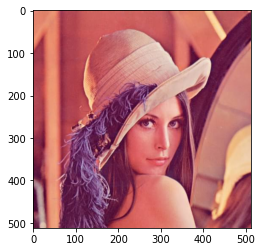

In [55]:
lena.show_img()

In [11]:
lena_gray = GrayScaleTransform('lena.jpg').to_gray()

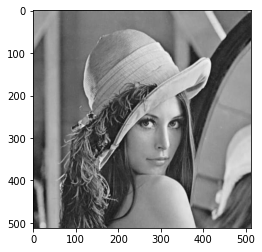

In [12]:
lena_gray.show_img()

In [13]:
sepia = GrayScaleTransform('lena.jpg').to_sepia(alpha_beta=(1.5, 0.5))

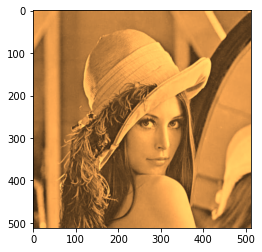

In [14]:
sepia.show_img()

In [15]:
sepia2 = GrayScaleTransform('lena.jpg').to_sepia(w=40)

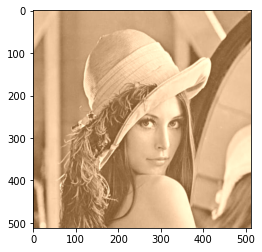

In [16]:
sepia2.show_img()

In [17]:
lena_histogram = Histogram(lena.data)

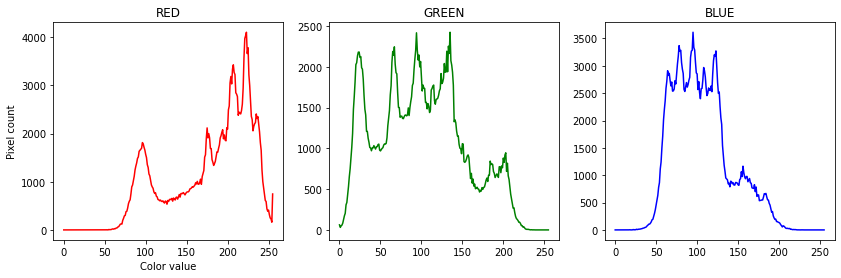

In [18]:
lena_histogram.plot()

In [19]:
lena_hsv = lena.to_hsv()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


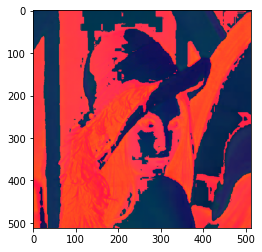

In [20]:
lena_hsv.show_img()

In [21]:
lena_hsv_to_rgb = lena_hsv.to_rgb()

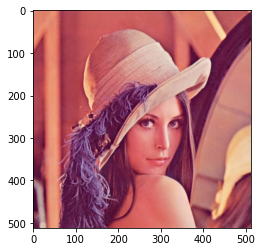

In [22]:
lena_hsv_to_rgb.show_img()

In [23]:
lena_hsl = lena.to_hsl()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


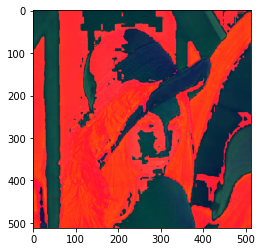

In [24]:
lena_hsl.show_img()

In [25]:
lena_hsl_to_rgb = lena_hsl.to_rgb()

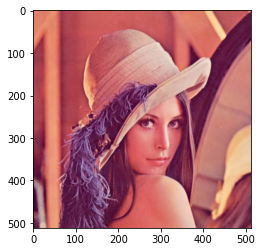

In [26]:
lena_hsl_to_rgb.show_img()

In [27]:
sp = BaseImage('sp.jpg')

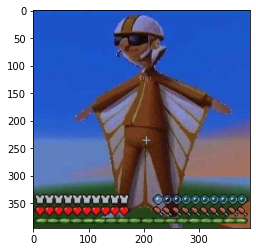

In [28]:
sp.show_img()

In [29]:
sp_hsl = sp.to_hsl()

<ipython-input-4-c3cb7c2e5b1d>:132: RuntimeWarning: invalid value encountered in double_scalars
  h = (((g - b) / delta) % 6) * 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


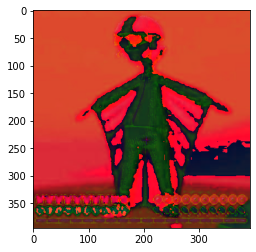

In [30]:
sp_hsl.show_img()

In [31]:
sp_hsl_to_rgb = sp_hsl.to_rgb()

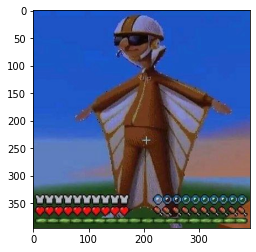

In [32]:
sp_hsl_to_rgb.show_img()